In [153]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data processing

Data directory location

In [166]:
data_dir = "data"

Set the image size (for resizing); batch size and seed 

In [167]:
batch_size = 32
image_size = (224,224)
seed = 10
validation_split = 0.3

Load in all images from the data directory

In [168]:
train_dataset = image_dataset_from_directory(data_dir, shuffle=True,image_size=image_size, subset= "training",validation_split = validation_split, seed = seed)
val_dataset = image_dataset_from_directory(data_dir, shuffle=True,image_size=image_size, subset= "validation",validation_split = validation_split, seed = seed)

Found 20933 files belonging to 42 classes.
Using 14654 files for training.
Found 20933 files belonging to 42 classes.
Using 6279 files for validation.


Let's look at the first nine images from the train dataset

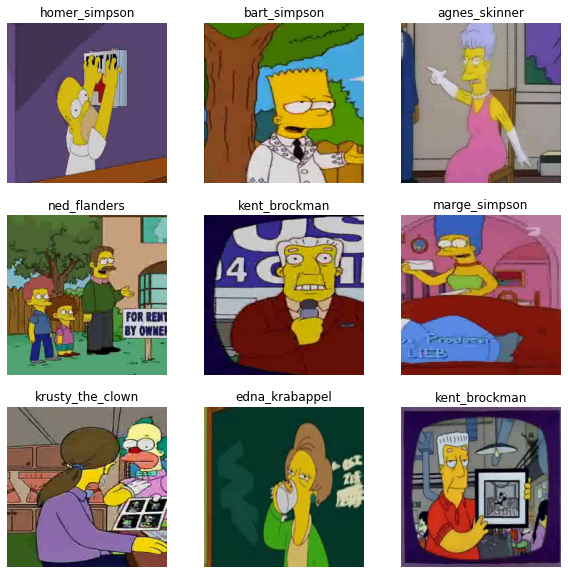

In [169]:
class_names = dataset.class_names
no_classes = len(class_names)
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Now get a test dataset from the validation set

In [170]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [171]:
print("Number of train batches: {}".format(tf.data.experimental.cardinality(train_dataset)))
print("Number of validation batches: {}".format(tf.data.experimental.cardinality(val_dataset)))
print("Number of test batches: {}".format(tf.data.experimental.cardinality(test_dataset)))

Number of train batches: 458
Number of validation batches: 158
Number of test batches: 39


Configure dataset for performance

In [172]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Dataset is of a good size but let's use augmentation anyway, to stop overfitting

In [173]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Demo of augmentation

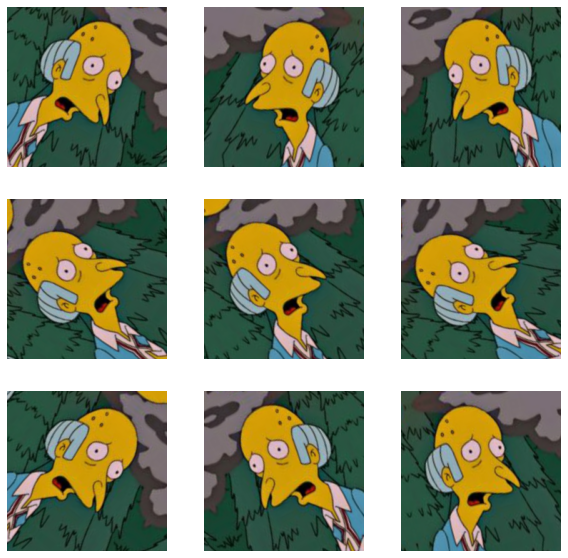

In [174]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Set up a rescalar (from [0-255] to [-1,1]), chosing tf.keras.applications.MobileNetV2 as the pretrained model 

In [175]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Loading the pre-trained model

- Chosing MobileNet V2 as the pretrained model
- Chosing the bottleneck layer as the layer to use for feature extraction

Create and instance of MobileNet V2 pre-loaded with weights trained on ImageNet. include_top=False means the loaded network doesn't include classification layers, useful for feature extraction

In [178]:
image_shape = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [179]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


### feature extraction

Freeze the convolutional base

In [180]:
base_model.trainable = False

Details on the model:

In [181]:
# base_model.summary()

Set a global average layer

In [182]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Add a prediction layer, 42 for the number of classes

In [183]:
prediction_layer = tf.keras.layers.Dense(no_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 42)


Set input shape, add the augmentation, processing

In [188]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Set learning rate, and compile the model

In [189]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [191]:
# model.summary()

In [192]:
initial_epochs = 15
loss0, accuracy0 = model.evaluate(val_dataset)

158/158 [==============================] - 91s 551ms/step - loss: 4.3865 - accuracy: 0.0374


In [193]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.38
initial accuracy: 0.04


In [194]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/15
458/458 [==============================] - 375s 813ms/step - loss: 2.7869 - accuracy: 0.4688 - val_loss: 2.2358 - val_accuracy: 0.5798
Epoch 2/15
458/458 [==============================] - 378s 824ms/step - loss: 2.2069 - accuracy: 0.5916 - val_loss: 1.9069 - val_accuracy: 0.6559
Epoch 3/15
458/458 [==============================] - 395s 861ms/step - loss: 2.0862 - accuracy: 0.6284 - val_loss: 2.3757 - val_accuracy: 0.6295
Epoch 4/15
458/458 [==============================] - 372s 812ms/step - loss: 2.0152 - accuracy: 0.6422 - val_loss: 2.5073 - val_accuracy: 0.6365
Epoch 5/15
458/458 [==============================] - 407s 888ms/step - loss: 2.1368 - accuracy: 0.6510 - val_loss: 2.7599 - val_accuracy: 0.6202
Epoch 6/15
458/458 [==============================] - 411s 898ms/step - loss: 2.1669 - accuracy: 0.6570 - val_loss: 2.7084 - val_accuracy: 0.6380
Epoch 7/15
458/458 [==============================] - 357s 778ms/step - loss: 2.0423 - accuracy: 0.6782 - val_loss: 2.9551 -

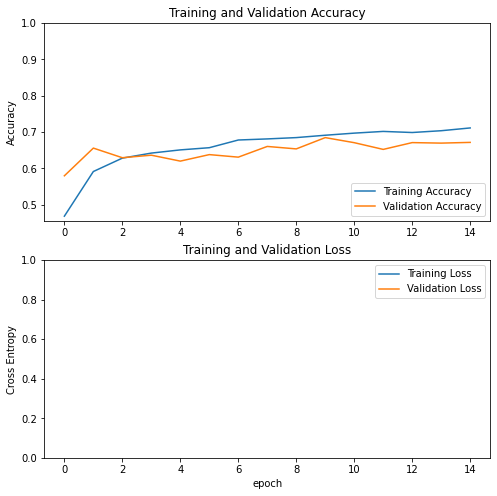

In [195]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [196]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Number of layers in the base model:  154
Epoch 15/25
458/458 [==============================] - 503s 1s/step - loss: 52.6611 - accuracy: 0.0641 - val_loss: 17.7430 - val_accuracy: 0.1044
Epoch 16/25
458/458 [==============================] - 494s 1s/step - loss: 42.0187 - accuracy: 0.0536 - val_loss: 14.9710 - val_accuracy: 0.1048
Epoch 17/25
458/458 [==============================] - 497s 1s/step - loss: 39.6857 - accuracy: 0.0551 - val_loss: 17.5909 - val_accuracy: 0.1044
Epoch 18/25
295/458 [==================>...........] - ETA: 2:25 - loss: 37.5565 - accuracy: 0.0561

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)